In [34]:
import dask.dataframe as bd
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import math
import os

In [35]:
origin_data = bd.read_csv(os.path.join(os.getcwd(), 'house.csv'))

In [36]:
origin_data = origin_data.compute()
origin_data = origin_data.drop_duplicates(subset=['title'])

In [37]:
td = origin_data.loc[:,['mean_price', 'capacity']].apply(lambda items: [re.match(r'^\d+', item).group(0) for item in items])
td = td.astype('int32')

In [38]:
final_data = pd.DataFrame()
final_data['mean_price'] = td['mean_price']
final_data['capacity'] = td['capacity']

In [39]:
final_data['time'] = [i[0:4] for i in origin_data['time']]

In [40]:
final_data['price'] = origin_data['price'].astype('int32')

In [41]:
area_map = {v: i for i, v in enumerate(origin_data.area.unique())}
region_map = {v: i for i, v in enumerate(origin_data.region.unique())}
area_map

{'余杭': 0,
 '上城': 1,
 '江干': 2,
 '钱塘新区': 3,
 '临安': 4,
 '滨江': 5,
 '下城': 6,
 '西湖': 7,
 '萧山': 8,
 '富阳': 9,
 '拱墅': 10,
 '杭州周边': 11,
 '建德': 12,
 '桐庐': 13,
 '淳安': 14}

In [42]:
area_map.keys()

dict_keys(['余杭', '上城', '江干', '钱塘新区', '临安', '滨江', '下城', '西湖', '萧山', '富阳', '拱墅', '杭州周边', '建德', '桐庐', '淳安'])

In [43]:
origin_data['area'].map(area_map)

0       0
1       0
2       1
3       2
4       3
       ..
2935    9
2936    4
2937    5
2938    3
2939    8
Name: area, Length: 2882, dtype: int64

In [44]:
from sklearn.preprocessing import LabelEncoder
gle = LabelEncoder()
genre_labels = gle.fit_transform(origin_data.area)
final_data['area'] = genre_labels
genre_labels = gle.fit_transform(origin_data.region)
final_data['region'] = genre_labels

In [45]:
area_map = dict(zip(area_map.values(), area_map.keys()))

([<matplotlib.axis.XTick at 0x1e9d3003c48>,
 <a list of 15 Text xticklabel objects>)

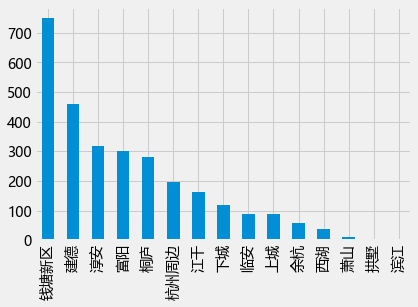

In [46]:
areas = pd.get_dummies(final_data['area']).astype('int32').sum(axis=0).sort_values(ascending=False)
areas.plot.bar()
areas_x = [area_map[i] for i in areas.index]
plt.xticks(list(range(len(areas_x))), areas_x, rotation=90)

In [47]:
region_dummies = pd.get_dummies(final_data['region']).astype('int32').sum(axis=0).sort_values(ascending=False)

In [48]:
region_map = dict(zip(region_map.values(), region_map.keys()))

In [49]:
regions_x = [region_map[i] for i in region_dummies.index]

In [50]:
def getColor(i):
    if i>75:
        return 'red'
    elif i > 50:
        return 'm'
    elif i > 25:
        return 'g'
    return 'blue'

region_colors = [getColor(i) for i in region_dummies.values]

([<matplotlib.axis.XTick at 0x1e9d847d088>,
 <a list of 133 Text xticklabel objects>)

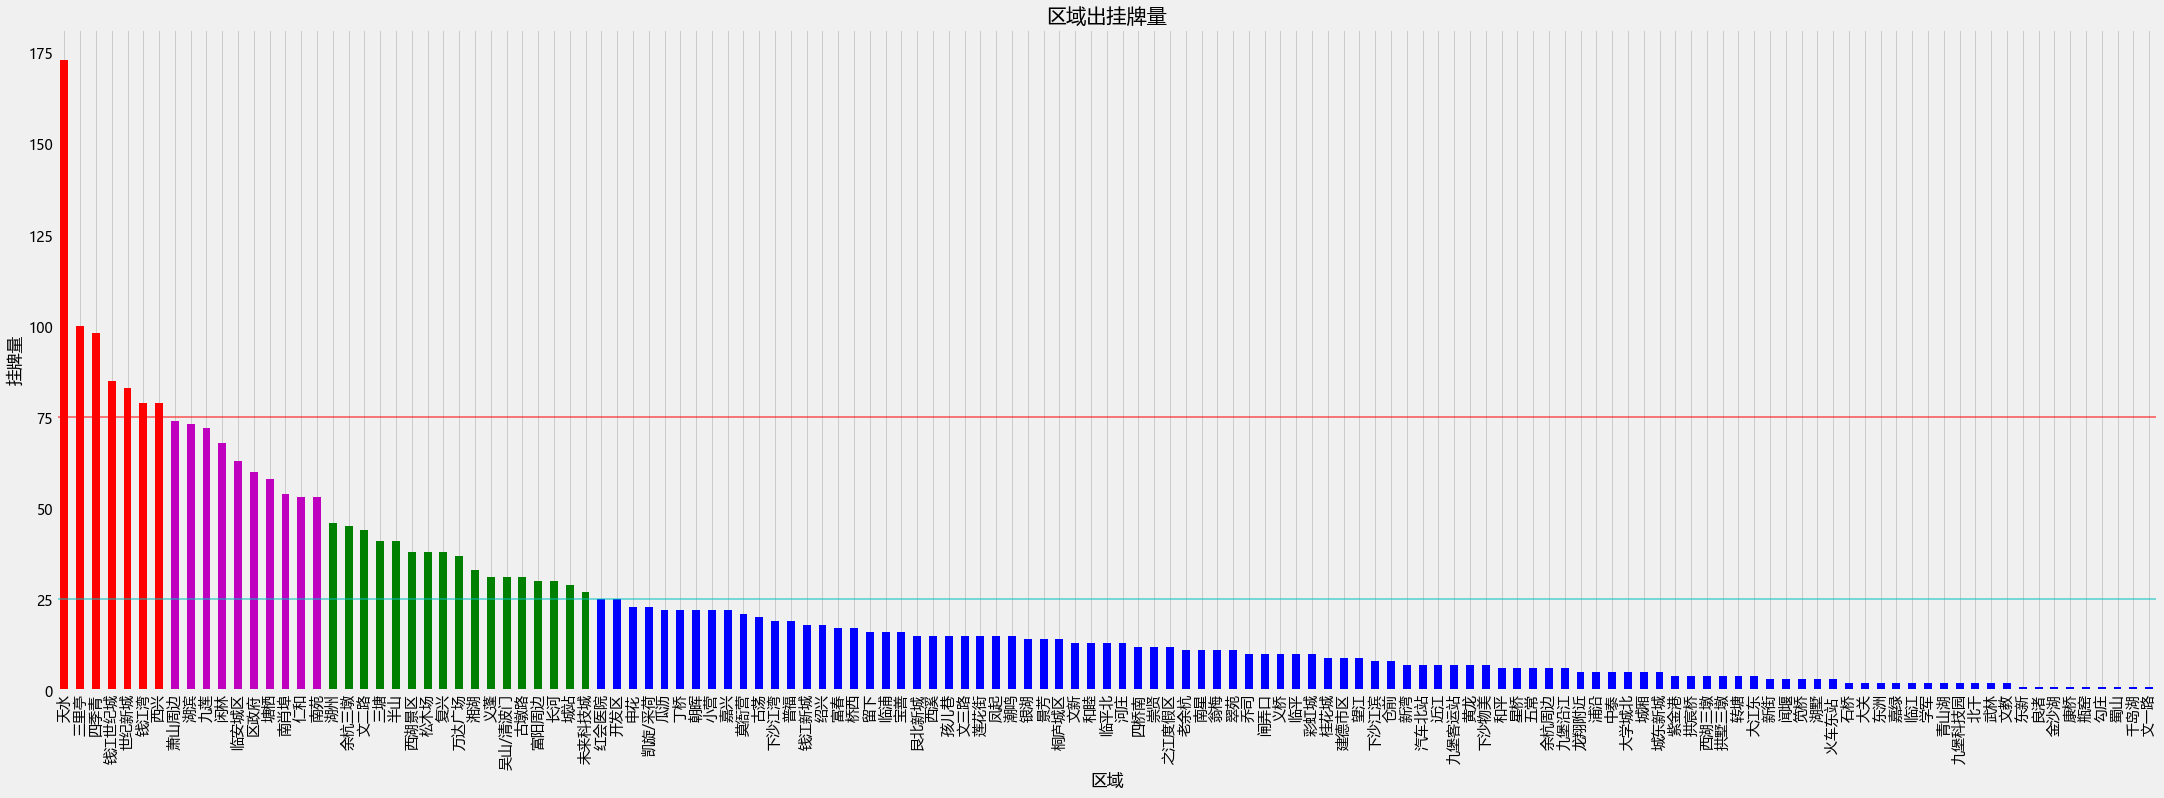

In [51]:
plt.style.use('fivethirtyeight')
fig = plt.figure(figsize=(30,10))
region_dummies.plot.bar(color=region_colors)
plt.grid(axis='y')
fig.tight_layout()
plt.axhline(y=75, linewidth=2, alpha=0.5, color='r')
plt.axhline(y=25, linewidth=2, alpha=0.5, color='c')
plt.title('区域出挂牌量')
plt.xlabel('区域')
plt.ylabel('挂牌量')
plt.xticks(list(range(len(regions_x))), regions_x, rotation=90)

In [52]:
final_data['room_type'] = origin_data['room_type'].map(lambda text: (text[0], text[2]) if len(text) == 4 else (text[0], 0))
final_data['room_type'].unique()

array([('2', '2'), ('4', '2'), ('3', '2'), ('2', '1'), ('5', '3'),
       ('3', '1'), ('1', '1'), ('5', '2'), ('1', 0), ('1', '2'),
       ('4', '3'), ('6', '2'), ('4', '1'), ('2', 0), ('6', '3'),
       ('6', '5'), ('5', '1'), ('3', '3'), ('7', '2'), ('7', '4'),
       ('6', '4'), ('4', '4'), ('8', '2'), ('2', '4'), ('2', '3'),
       ('5', '5'), ('7', '3')], dtype=object)

In [53]:
final_data['house_level'] = origin_data.loc[:,['house_type']].apply(lambda items: [re.search(r'\d+', item).group(0) for item in items]).astype('int32')

### 区域及地区混合变量

In [54]:
final_data['area'] = final_data['area'] + 1
final_data['region'] = final_data['region'] + 1

In [55]:
from sklearn.preprocessing import PolynomialFeatures
pf = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
res = pf.fit_transform(final_data[['area', 'region']])
pos_df = pd.DataFrame(res, columns=['area', 'region', 'position'])

In [59]:
pos_df.describe()

,area,region,position
count,2882.000000,2882.000000,2882.000000
mean,8.869188,66.017696,622.379598
std,4.656313,43.989799,569.662798
min,1.000000,1.000000,6.000000
25%,4.000000,20.250000,104.250000
50%,10.000000,65.000000,428.000000
75%,13.000000,110.750000,1001.000000
max,15.000000,133.000000,1848.000000


In [60]:
final_data['position'] = pos_df['position']

In [61]:
room_zip = zip(*final_data['room_type'].values)
room_no, lobby_no = room_zip
con_np = np.array([[int(r) + 1, l, s] for r, l, s in zip(room_no, lobby_no, final_data['house_level'])]).astype('int32')
pf = PolynomialFeatures(degree=3, interaction_only=True, include_bias=False)
res = pf.fit_transform(con_np)
final_data['type'] = res[:,-1]

### 价格分档

0.00      3690.00
0.25     12303.50
0.50     17890.00
0.75     26997.75
1.00    168744.00
Name: mean_price, dtype: float64

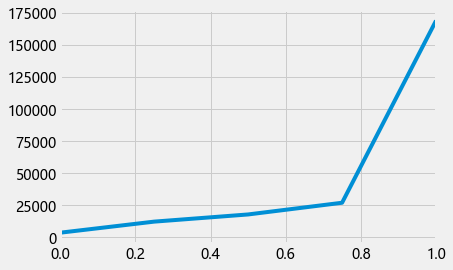

In [62]:
quant_list = [0, .25, .5, .75, 1]
mean_prices = final_data['mean_price'].quantile(quant_list)
mean_prices.plot()
mean_prices

0.00       7.0
0.25      63.0
0.50     100.0
0.75     230.0
1.00    6500.0
Name: price, dtype: float64

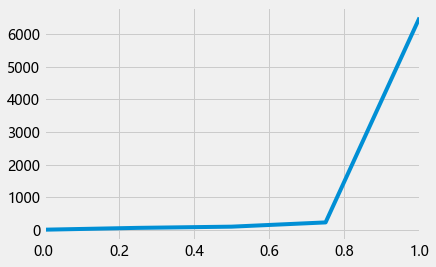

In [63]:
prices = final_data['price'].quantile(quant_list)
prices.plot()
prices

In [66]:
qt_labels = [1,2,3,4]
final_data['mean_price_level'] = pd.qcut(final_data['mean_price'], q=quant_list, labels=qt_labels)
final_data['price_level'] = pd.qcut(final_data['price'], q=quant_list, labels=qt_labels)

### 词语处理

In [65]:
import nltk

In [67]:
import jieba
from jieba.analyse import extract_tags
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

def extract_word(title):
    words = jieba.lcut(title)
    return extract_tags(title, topK=3)

texts = []
for t in origin_data['title'].values:
    texts.extend(t)

cv = CountVectorizer(analyzer='word', max_features=500)
cv_fit = cv.fit_transform(origin_data['title'].values)
tv = TfidfVectorizer(analyzer='word', max_features=500)
tv_fit = tv.fit_transform(origin_data['title'].values)

In [32]:
cv_fit

<2882x500 sparse matrix of type '<class 'numpy.int64'>'
	with 6127 stored elements in Compressed Sparse Row format>

In [68]:
final_data.shape

(2882, 12)

In [69]:
final_data['title'] = origin_data['title']
final_data['labels'] = origin_data['labels']

In [70]:
final_data.head()

,mean_price,capacity,time,price,area,region,room_type,house_level,position,type,mean_price_level,price_level,title,labels
0,24626,80,2014,199,4,128,"(2, 2)",32,512.0,192.0,3,3,自住装修，坐拥加州风格大湖，楼层视野佳，置换诚心出售，随时看,"['环境优美', '次新小区', '品质小区']"
1,24807,76,2013,190,4,109,"(2, 2)",18,436.0,108.0,3,3,复地上城 近地铁 满两年 总价醉低的两房 中间楼层 采光充足,"['近地铁', '配套成熟', '次新小区']"
2,42216,75,2006,320,1,121,"(2, 2)",33,121.0,198.0,4,4,出门近江地铁口，天地學区房，电梯2房朝南东边套，视野好采光好,"['近地铁', '近学校', '南北通透']"
3,58835,147,2008,870,10,124,"(4, 2)",33,1240.0,330.0,4,4,全景VR看房钱江新城金基晓庐跃层 4房2厅2卫 急降50万,"['近地铁', '南北通透']"
4,4600,50,2014,23,15,56,"(2, 2)",11,840.0,66.0,1,1,急售！急售！急售！房东破产，急需大量钱周转，一口价20万,"['近地铁', '配套成熟', '品质小区']"


In [122]:
final_data = final_data.reset_index(drop=True)
final_data = final_data.drop(['position'], axis=1)

In [124]:
final_data['position'] = pos_df['position']

In [125]:
final_data.describe()

,mean_price,capacity,price,area,region,house_level,type,position
count,2882.000000,2882.000000,2882.000000,2882.000000,2882.000000,2882.000000,2882.000000,2882.000000
mean,21609.604441,81.609993,210.007634,8.869188,66.017696,16.331020,115.436155,622.379598
std,13196.401478,68.150984,346.595974,4.656313,43.989799,8.235602,75.373615,569.662798
min,3690.000000,10.000000,7.000000,1.000000,1.000000,1.000000,0.000000,6.000000
25%,12303.500000,47.000000,63.000000,4.000000,20.250000,11.000000,66.000000,104.250000
50%,17890.000000,68.000000,100.000000,10.000000,65.000000,16.000000,96.000000,428.000000
75%,26997.750000,89.000000,230.000000,13.000000,110.750000,20.000000,144.000000,1001.000000
max,168744.000000,985.000000,6500.000000,15.000000,133.000000,56.000000,900.000000,1848.000000


In [126]:
final_data.head()

,mean_price,capacity,time,price,area,region,room_type,house_level,type,mean_price_level,price_level,title,labels,position
0,24626,80,2014,199,4,128,"(2, 2)",32,192.0,3,3,自住装修，坐拥加州风格大湖，楼层视野佳，置换诚心出售，随时看,"['环境优美', '次新小区', '品质小区']",512.0
1,24807,76,2013,190,4,109,"(2, 2)",18,108.0,3,3,复地上城 近地铁 满两年 总价醉低的两房 中间楼层 采光充足,"['近地铁', '配套成熟', '次新小区']",436.0
2,42216,75,2006,320,1,121,"(2, 2)",33,198.0,4,4,出门近江地铁口，天地學区房，电梯2房朝南东边套，视野好采光好,"['近地铁', '近学校', '南北通透']",121.0
3,58835,147,2008,870,10,124,"(4, 2)",33,330.0,4,4,全景VR看房钱江新城金基晓庐跃层 4房2厅2卫 急降50万,"['近地铁', '南北通透']",1240.0
4,4600,50,2014,23,15,56,"(2, 2)",11,66.0,1,1,急售！急售！急售！房东破产，急需大量钱周转，一口价20万,"['近地铁', '配套成熟', '品质小区']",840.0


In [121]:
final_data.to_csv('final_data.csv')